In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
# local imports
import sys
sys.path.insert(1, '../')
from utilities import utilities
#from ..utilities import utilities

In [2]:
# configure tqdm printing
#%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [3]:
path = '../physiobank_tool/ptbdb'
number_of_segments = 120
low_cut = 3 # specific for this dataset
FILE_ASSEMBLY = False

In [4]:
files = []
if FILE_ASSEMBLY:
    with open(path+'/header.txt') as f:
        reader = csv.reader(f)
        for row in reader:
            #print(row)
            files.append(row[0])
    print("Read data for the following drivers:\n", files[:10])

In [5]:
if FILE_ASSEMBLY:
    #Gets a list of unique patients that will be used to unify all the files from a single patient
    unique_patients = list(set([file.split('/')[0] for file in files]))


    #This loop will iterate through all the unique patients, searching for their files in the database.
    #As soon as they're found, they're read and added to a dataframe. Care is required with the column
    #time that is reset at each file, but our file must diffferentiate these timestamps!

    for patient in tqdm(unique_patients):#[:1]:
        patient_data = pd.DataFrame()
        last_finishing_time = 0
        for file in files:
            if patient in file:
                file = file.replace("/", "")

                cols_of_interest = [0,1]
                df = pd.read_csv(path+"/"+file, usecols=cols_of_interest, names=['time', 'ECG'])

                df = df.drop(df.index[:2])

                df['time'] = df['time'].astype(float)
                df['ECG'] = df['ECG'].astype(float)

                df['time'] = df['time'] + last_finishing_time
                df['Group'] = file

                patient_data = pd.concat([patient_data, df])

                last_finishing_time = float(patient_data.iloc[:, [0]].iloc[-1])
                #print("LAST:", last_finishing_time)
        patient_data.to_csv(f"{path}/per_patient/{patient}.csv", index=False)
    

In [6]:
path = "../physiobank_tool/ptbdb/per_patient"
with open(path+'/header.txt') as f:
    reader = csv.reader(f)
    for row in reader:
        #print(row)
        files.append(row[0])
print("Read data for the following drivers:\n", files[:10])

Read data for the following drivers:
 ['patient082', 'patient238', 'patient259', 'patient026', 'patient184', 'patient066', 'patient084', 'patient203', 'patient197', 'patient243']


In [7]:
def read_file(file_name):
    ''' Read ecg information from a file and saves it to a dataframe  '''
    cols_of_interest = [0,1]
    ecg_data = pd.read_csv(f'{path}/{file_name}.csv', usecols=cols_of_interest)
    # drop useless header
    ecg_data = ecg_data.drop(ecg_data.index[0])
    # name columns
    ecg_data.columns = ['time', 'ECG']
    # cast some columns to float
    ecg_data['time'] = ecg_data['time'].astype(float)
    ecg_data['ECG'] = ecg_data['ECG'].astype(float)
    
    return ecg_data

In [8]:
def run(ecg_data, file_name, number_of_segments, low_cut):
    """Execute the pipeline that segmentate and extract the features of a ecg signal 
    inputted as a dataframe"""
    sample_rate = utilities.detect_sample_rate(ecg_data)
    high_cut = sample_rate/3.0
    
    data_preparation_pipeline = Pipeline([
        ('filtering', utilities.Filter(sample_rate, low_cut, high_cut)),
        ('feature_detection', utilities.FeatureExtractor(number_of_segments, sample_rate)),
        ])

    extracted_features_df = data_preparation_pipeline.fit_transform(ecg_data['ECG'])
    extracted_features_df.reset_index(drop=True, inplace=True)
    return extracted_features_df

In [9]:
# A final dataframe to store all subjects (people) ecg information 
features_df = pd.DataFrame()
# read every file and return the dataframe of extracted features for ech file
files = []
with open(path+'/header.txt') as f:
    reader = csv.reader(f)
    for row in reader:
        #print(row)
        files.append(row[0])

for file in tqdm(files):
    ecg_data = read_file(file)
    current_df = run(ecg_data, file, number_of_segments, low_cut)
    current_df['person'] = file
    features_df = pd.concat([current_df, features_df], ignore_index=True)

    

/home/renato/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/renato/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
# Check an example
print(features_df.head(5))

     mean_q    mean_r    mean_s   stdev_q   stdev_r   stdev_s  \
0       NaN       NaN       NaN       NaN       NaN       NaN   
1  0.027978  0.481317 -0.134032  0.079029  0.062680  0.350638   
2 -0.046426  0.575340 -0.497651  0.004666  0.020738  0.000024   
3 -0.001467  0.507877 -0.134429  0.043618  0.088502  0.379530   
4 -0.005907  0.495935 -0.123944  0.041709  0.065014  0.382317   

   mean_qrs_interval  mean_rr_interval  mean_rq_amplitude      person  
0                NaN               NaN                NaN  patient288  
1              626.0          0.453338               65.5  patient288  
2             1013.0          0.621766               59.5  patient288  
3             1415.0          0.509344               70.0  patient288  
4              635.0          0.501841               69.0  patient288  


In [11]:
# check if we have equivalent number of examples per class   
#features_df['person'].value_counts()

In [12]:
# Save the final extracted features
now = str(datetime.now())
features_df.to_csv(f"../extracted_features_files/ptbdb.csv", index=False)

In [13]:
## Examples below

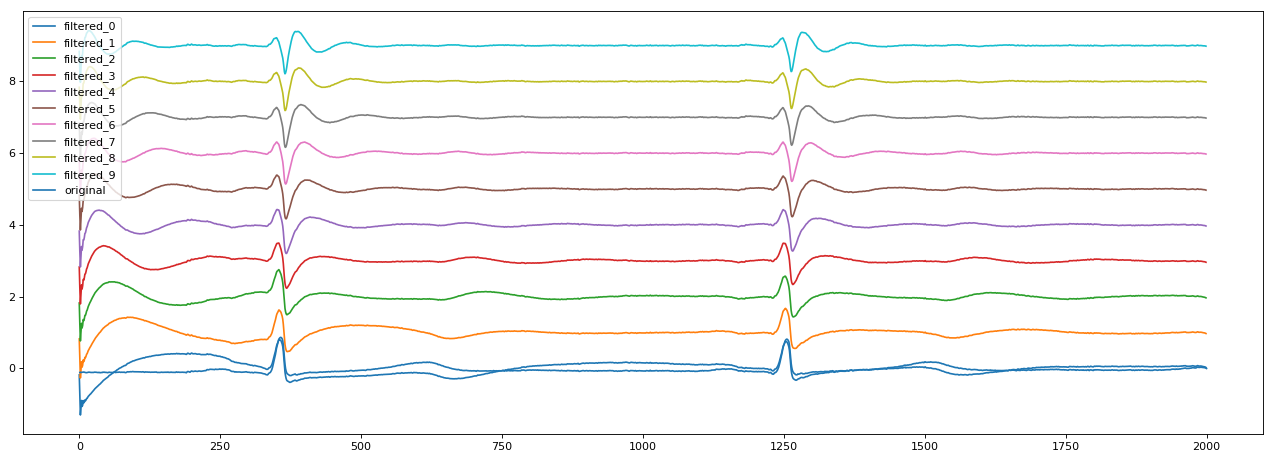

In [14]:
ecg_data = read_file(files[1])
sample_rate = utilities.detect_sample_rate(ecg_data)
two_seconds = ecg_data['ECG'][0:sample_rate*2]
plt.figure(figsize=(20, 7), dpi= 80, facecolor='w', edgecolor='k')

list_of_filters = [utilities.Filter(sample_rate, x, sample_rate/3.0) for x in np.linspace(1, 10, 10)]
list_of_filtered_signals = [x.fit_transform(two_seconds) + index for index, x in enumerate(list_of_filters)]

for index, signal in enumerate(list_of_filtered_signals):
    plt.plot(signal, label=f'filtered_{index}')
plt.plot(two_seconds+1.0, label='original')
plt.legend()